# 5. Routing 3: Vehicle Routing
`ISE 754, Fall 2024`

__Package Used:__ No new packages used.

## Ex 1: TSP: Unconstrained tour (cyclic route)

Dataset of 30 NC Shipments, `shmtNC30-sh.csv`, and 54 different begin-end locations, `shmtNC30-xy.cxv`. Will use the ending location of shipment 1 as the depot and the beginning locations of the shipments and their ending locations to create a peddling scenario.

#### Load Dataset:

In [1]:
using Logjam.DataTools, DataFrames, CSV

sh = DataFrame(CSV.File("shmtNC30-sh.csv"))
@show nrow(sh)
first(sh, 5)

nrow(sh) = 30


Row,b,e,s,v,q,f
,Int64,Int64,Float64,Float64,Float64,Float64
1,15,42,1.1744,683.186,0.260293,2.1339
2,26,27,5.46358,691.299,0.624343,4.22327
3,23,40,15.2286,5843.73,0.890179,6.27164
4,53,51,5.70972,383.708,0.561644,6.40556
5,17,32,13.8174,2776.55,0.71779,6.32393


In [2]:
dfxy = DataFrame(CSV.File("shmtNC30-xy.csv"))
@show nrow(dfxy)
first(dfxy, 5)

nrow(dfxy) = 54


Row,x,y
,Float64,Float64
1,-79.9746,36.4214
2,-79.9052,36.4727
3,-80.19,36.0462
4,-80.2617,36.0394
5,-79.4114,36.1327


#### Add depot:
Use end location of shipment 1 as the depot for all shipments

In [3]:
x, y = eachcol(dfxy[[sh.e[1]; sh.b], :])
@show length(x)
hcat(first(x, 5), first(y, 5))

length(x) = 31


5×2 Matrix{Float64}:
 -79.3908  35.1804
 -78.797   35.7979
 -77.3384  35.5792
 -78.5861  35.7678
 -82.3001  35.8913

In [4]:
function dgc(xy₁, xy₂; unit=:mi)
    length(xy₁) == length(xy₂) == 2 || error("Inputs must have length 2.")
    unit in [:mi, :km] || error("Unit must be :mi or :km")

    Δx, Δy = xy₂[1] - xy₁[1], xy₂[2] - xy₁[2]
    a = sind(Δy / 2)^2 + cosd(xy₁[2]) * cosd(xy₂[2]) * sind(Δx / 2)^2
    2 * asin(min(sqrt(a), 1.0)) * (unit == :mi ? 3958.75 : 6371.00)
end

Dgc(X₁, X₂) = [dgc(i, j) for i in eachrow(X₁), j in eachrow(X₂)]

D = Dgc(hcat(x, y), hcat(x, y)) * 1.2
@show size(D)
tr = (b = 1, e = 1)
sh.b .= 1
sh.e .= 2:length(x)
@show nrow(sh)
first(sh, 5)

size(D) = (31, 31)
nrow(sh) = 30


Row,b,e,s,v,q,f
,Int64,Int64,Float64,Float64,Float64,Float64
1,1,2,1.1744,683.186,0.260293,2.1339
2,1,3,5.46358,691.299,0.624343,4.22327
3,1,4,15.2286,5843.73,0.890179,6.27164
4,1,5,5.70972,383.708,0.561644,6.40556
5,1,6,13.8174,2776.55,0.71779,6.32393


#### Construct & improve routes:

In [5]:
include("rtefun.jl")

rTCh(rte) = rteTC(rte, sh, D, tr)
r1 = savings(rTCh, sh)[1]
r1, TD1 = twoopt(r1, rTCh)
@show length(r1)
@show r1
TD1

length(r1) = 60
r1 = [18, 21, 11, 16, 17, 4, 22, 29, 23, 14, 7, 15, 13, 6, 20, 19, 12, 27, 1, 5, 3, 10, 24, 26, 25, 30, 9, 8, 28, 2, 21, 11, 18, 16, 10, 9, 8, 28, 2, 25, 30, 26, 24, 3, 5, 17, 1, 27, 19, 20, 6, 12, 13, 15, 22, 4, 23, 29, 14, 7]


1162.6684180317714

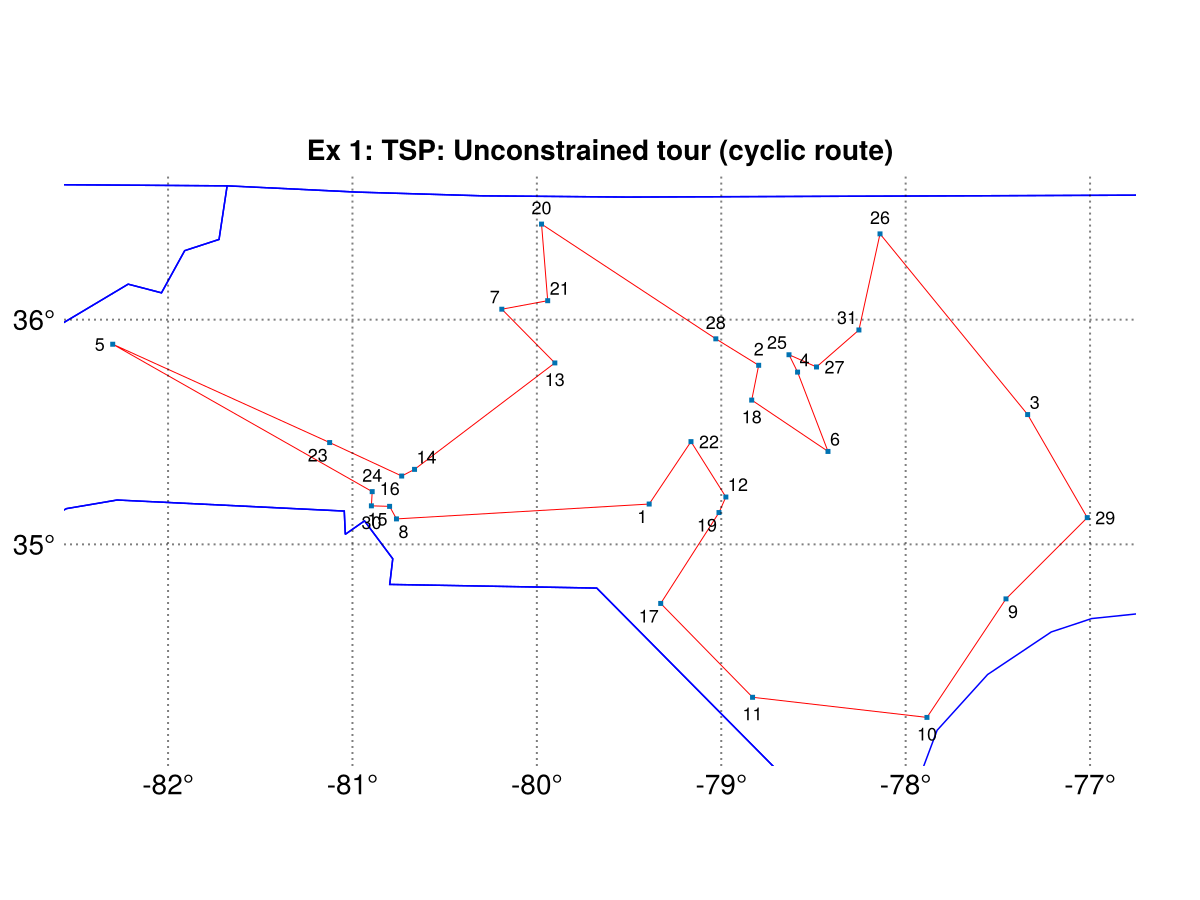

In [6]:
using CairoMakie, Logjam.MapTools

fig, ax = makemap(x, y; xexpand=0.05)
loc = rte2loc(r1, sh, tr)
lines!(ax, x[loc], y[loc], color=:red, linewidth=.5)
scatter!(ax, x, y; marker='.', markersize=24)
text!(ax, x, y, text=string.(1:length(x)); fontsize=9, aligntext(x, y)...)
ax.title = "Ex 1: TSP: Unconstrained tour (cyclic route)"
fig

## Ex 2: VRP: Ex 1 + Add max route distance constraint

In [7]:
include("rtefun.jl")

maxdist = 600
function rTCh(rte)
    rTD = rteTC(rte, sh, D, tr)
    return rTD < maxdist ? rTD : Inf
end
@show rTCh([1, 2, 3, 3, 2, 1])
@show rTCh([1, 2, 3, 4, 4, 3, 2, 1])
mincostinsert(4, [1, 2, 3, 3, 2, 1], rTCh)

rTCh([1, 2, 3, 3, 2, 1]) = 323.3615070724538
rTCh([1, 2, 3, 4, 4, 3, 2, 1]) = Inf


([1, 2, 3, 3, 2, 1], Inf)

In [8]:
r2 = savings(rTCh, sh)
TD2 = [rTCh(ri) for ri in r2]
@show sum(TD2)
TD2

sum(TD2) = 1329.3343108669978


3-element Vector{Float64}:
 598.0551628199303
 556.1368767607001
 175.14227128636725

In [9]:
r2 = [twoopt(ri, rTCh)[1] for ri in r2]
@show TD2 = [rTCh(ri) for ri in r2]
@show sum(TD2)
r2

TD2 = [rTCh(ri) for ri = r2] = [598.0551628199303, 537.7064917996254, 175.14227128636725]
sum(TD2) = 1310.903925905923


3-element Vector{Vector{Int64}}:
 [11, 27, 1, 5, 3, 10, 24, 26, 25, 30  …  2, 25, 30, 26, 3, 24, 27, 1, 5, 11]
 [12, 19, 20, 6, 13, 15, 7, 14, 23, 29  …  19, 6, 4, 22, 13, 15, 23, 29, 14, 7]
 [16, 18, 21, 17, 21, 17, 18, 16]

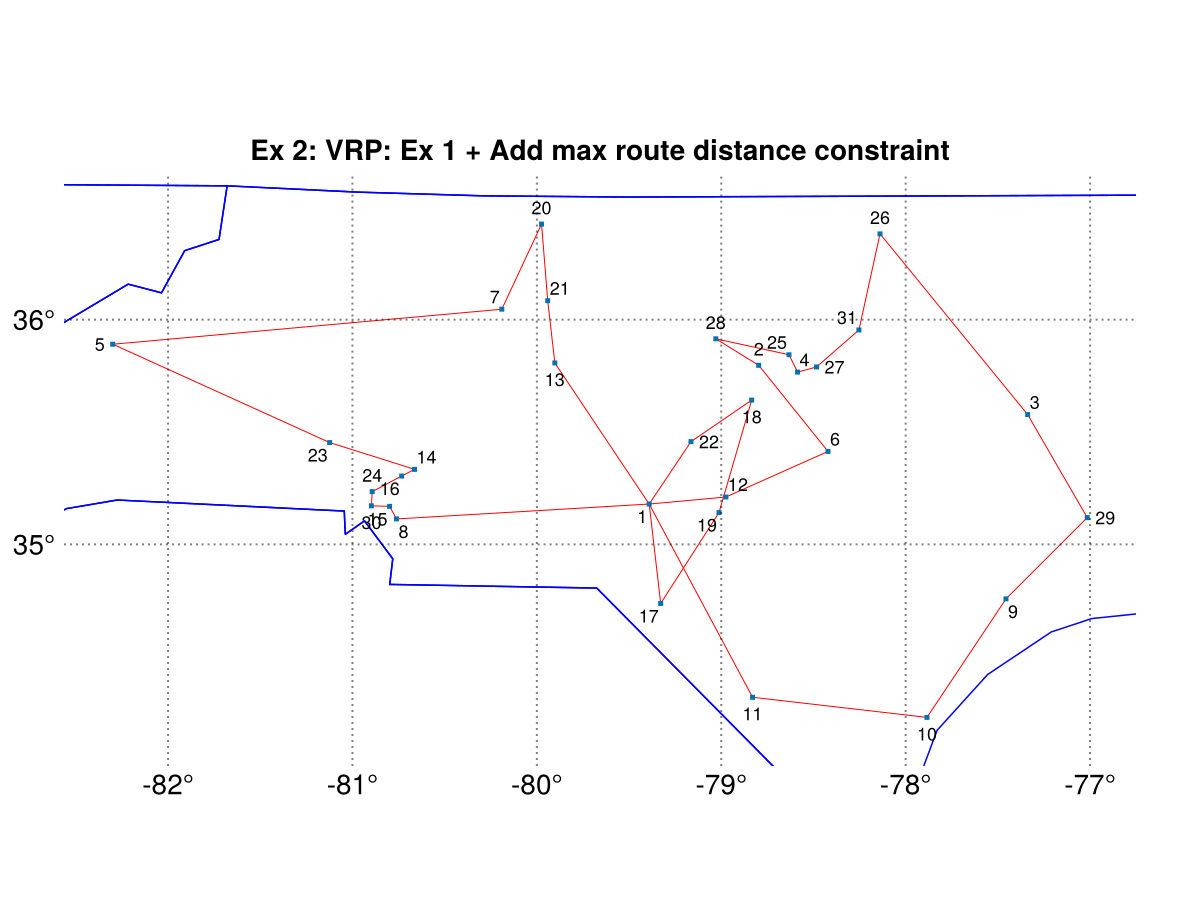

In [10]:
fig, ax = makemap(x, y; xexpand=0.05)
for ri = r2
    loc = rte2loc(ri, sh, tr)
    lines!(ax, x[loc], y[loc], color=:red, linewidth=.5)
end
scatter!(ax, x, y; marker='.', markersize=24)
text!(ax, x, y, text=string.(1:length(x)); fontsize=9, aligntext(x, y)...)
ax.title = "Ex 2: VRP: Ex 1 + Add max route distance constraint"
fig

## Ex 3: VRP: Ex 1 + Add max time constraint

In [11]:
include("rtefun.jl")

maxtime = 11   # hr
v = 60         # mph
T = D ./ v
sh.tLU .= 1/3  # hr (20 min)
first(sh, 5)

Row,b,e,s,v,q,f,tLU
,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,1,2,1.1744,683.186,0.260293,2.1339,0.333333
2,1,3,5.46358,691.299,0.624343,4.22327,0.333333
3,1,4,15.2286,5843.73,0.890179,6.27164,0.333333
4,1,5,5.70972,383.708,0.561644,6.40556,0.333333
5,1,6,13.8174,2776.55,0.71779,6.32393,0.333333


In [12]:
function rTCh(rte)
    rTT = rteTC(rte, sh, T, tr)
    rTT += sum(sh.tLU[unique(rte)])
    return rTT < maxtime ? rTT : Inf
end

r3 = savings(rTCh, sh)
TT3 = [rTCh(ri) for ri in r3]
@show sum(TT3)
TT3

sum(TT3) = 35.417721886273135


4-element Vector{Float64}:
 10.623698067005588
 10.957514231202886
  9.8066231213518
  4.02988646671286

In [13]:
r3 = [twoopt(ri, rTCh)[1] for ri in r3]
@show TT3 = [rTCh(ri) for ri in r3]
@show sum(TT3)
TT3

TT3 = [rTCh(ri) for ri = r3] = [10.09367877625182, 10.957514231202886, 9.8066231213518, 4.02988646671286]
sum(TT3) = 34.887702595519364


4-element Vector{Float64}:
 10.09367877625182
 10.957514231202886
  9.8066231213518
  4.02988646671286

## Ex 4: VRP: Ex 1 + Add customer demands and truck capacity

In [14]:
include("rtefun.jl")

tr = (b = 1, e = 1, Kwt = 25, Kcu = 2750)

function rTCh(rte)
    rTD = rteTC(rte, sh, D, tr)
    idxsh = unique(rte)
    wtfeas = sum(sh.q[idxsh]) <= tr.Kwt
    cufeas = sum(2000sh.q[idxsh]./sh.s[idxsh]) <= tr.Kcu
    return wtfeas && cufeas ? rTD : Inf
end

r4 = savings(rTCh, sh)
TD4 = [rTCh(ri) for ri in r4]
@show sum(TD4)
r4

sum(TD4) = 1198.8012892217432


2-element Vector{Vector{Int64}}:
 [18, 21, 11, 16, 17, 27, 1, 5, 3, 10  …  26, 3, 24, 27, 1, 17, 5, 11, 18, 21]
 [12, 19, 20, 6, 13, 15, 7, 14, 23, 29  …  19, 6, 13, 15, 22, 4, 23, 29, 14, 7]

In [15]:
r4 = [twoopt(ri, rTCh)[1] for ri in r4]
@show TD4 = [rTCh(ri) for ri in r4]
@show sum(TD4)
TD4

TD4 = [rTCh(ri) for ri = r4] = [640.0878755351481, 537.7064917996254]
sum(TD4) = 1177.7943673347736


2-element Vector{Float64}:
 640.0878755351481
 537.7064917996254

In [16]:
idxsh = unique(r4[1])
@show sum(sh.q[idxsh])
@show sum(2000sh.q[idxsh]./sh.s[idxsh])
idxsh = unique(r4[2])
@show sum(sh.q[idxsh])
@show sum(2000sh.q[idxsh]./sh.s[idxsh]);

sum(sh.q[idxsh]) = 8.812864415725471
sum((2000 * sh.q[idxsh]) ./ sh.s[idxsh]) = 2253.854557932724
sum(sh.q[idxsh]) = 8.921280625587118
sum((2000 * sh.q[idxsh]) ./ sh.s[idxsh]) = 1541.5176675532693
